In [1]:
import sys
sys.path.append("../")

from jax import numpy as jnp
from jax import Array, random

from src.ode import Exponential, VanDerPol
from src.solvers import RKF45
from src.solvers.rksolver import RKSolver

In [3]:
# Configuration of VanDerPol taken from "Kersting, H., & Hennig, P. (2016). Active uncertainty calibration in Bayesian ODE solvers."

solvers = {"Runge-Kutta-Fehlberg 4(5)": RKF45}
odes = {"Exponential Decay": Exponential(growth_factor=jnp.array(-0.5)), "Van der Pol Oscillator": VanDerPol(jnp.array(5))}
x0 = {"Exponential Decay": jnp.array([[[1.0]]]), "Van der Pol Oscillator": jnp.array([[[2.0], [10.0]]])}
t0 = {"Exponential Decay": jnp.array([0.0]), "Van der Pol Oscillator": jnp.array([10.0])}
tN = {"Exponential Decay": jnp.array(10.0), "Van der Pol Oscillator": jnp.array(60.0)}
tS = {"Exponential Decay": jnp.array(0.1), "Van der Pol Oscillator": jnp.array(0.5)}
dts = jnp.array([0.01, 0.05, 0.07, 0.09, 0.095, 0.099, 0.1])

prng_key = random.key(7)

In [11]:
def perturbation_test(solver: RKSolver, tN: Array, tS: Array, prng_key: Array, num_perturbations: int = 100):
    ts = [solver.t[0]]
    xss = [jnp.broadcast_to(solver.x, (num_perturbations,) + solver.x.shape[-2:])]
    
    while jnp.any(solver.t < tN):
        print(f"{solver.t[0].item()} < {tN.item()}", end="\r")
        
        t, x, eps = solver.step()  # [P, N, D]
        prng_key, subkey = random.split(prng_key)
        p = eps * random.normal(subkey, shape=(num_perturbations,) + eps.shape[-2:])  # [P, N, D]
        x_p = x + p  # [P, N, D]
        solver.x = x_p
        
        xss.append(x_p)
        ts.append(t[0])
    return ts, xss

In [12]:
results = {k1: {k2: {k3.item(): None for k3 in dts} for k2 in odes} for k1 in solvers}

for k1, solver_cls in solvers.items():
    for k2, ode in odes.items():
        for dt in dts:
            print(k1, k2, dt.item())
            solver = solver_cls(ode, t0[k2], x0[k2], dt)
            prng_key, subkey = random.split(prng_key)
            ts, xss = perturbation_test(solver, tN[k2], tS[k2], subkey)
            results[k1][k2][dt.item()] = (jnp.stack(ts), jnp.stack(xss, axis=1))  # type: ignore

Runge-Kutta-Fehlberg 4(5) Exponential Decay 0.01
Runge-Kutta-Fehlberg 4(5) Exponential Decay 0.05
Runge-Kutta-Fehlberg 4(5) Exponential Decay 0.07
Runge-Kutta-Fehlberg 4(5) Exponential Decay 0.09
Runge-Kutta-Fehlberg 4(5) Exponential Decay 0.095
Runge-Kutta-Fehlberg 4(5) Exponential Decay 0.099
Runge-Kutta-Fehlberg 4(5) Exponential Decay 0.1
Runge-Kutta-Fehlberg 4(5) Van der Pol Oscillator 0.01
Runge-Kutta-Fehlberg 4(5) Van der Pol Oscillator 0.05
Runge-Kutta-Fehlberg 4(5) Van der Pol Oscillator 0.07
Runge-Kutta-Fehlberg 4(5) Van der Pol Oscillator 0.09
Runge-Kutta-Fehlberg 4(5) Van der Pol Oscillator 0.095
Runge-Kutta-Fehlberg 4(5) Van der Pol Oscillator 0.099
Runge-Kutta-Fehlberg 4(5) Van der Pol Oscillator 0.1


In [13]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from tueplots import bundles
from tueplots.constants.color import rgb

plt.rcParams.update(bundles.beamer_moml())
colors = [rgb.tue_red, rgb.tue_blue]

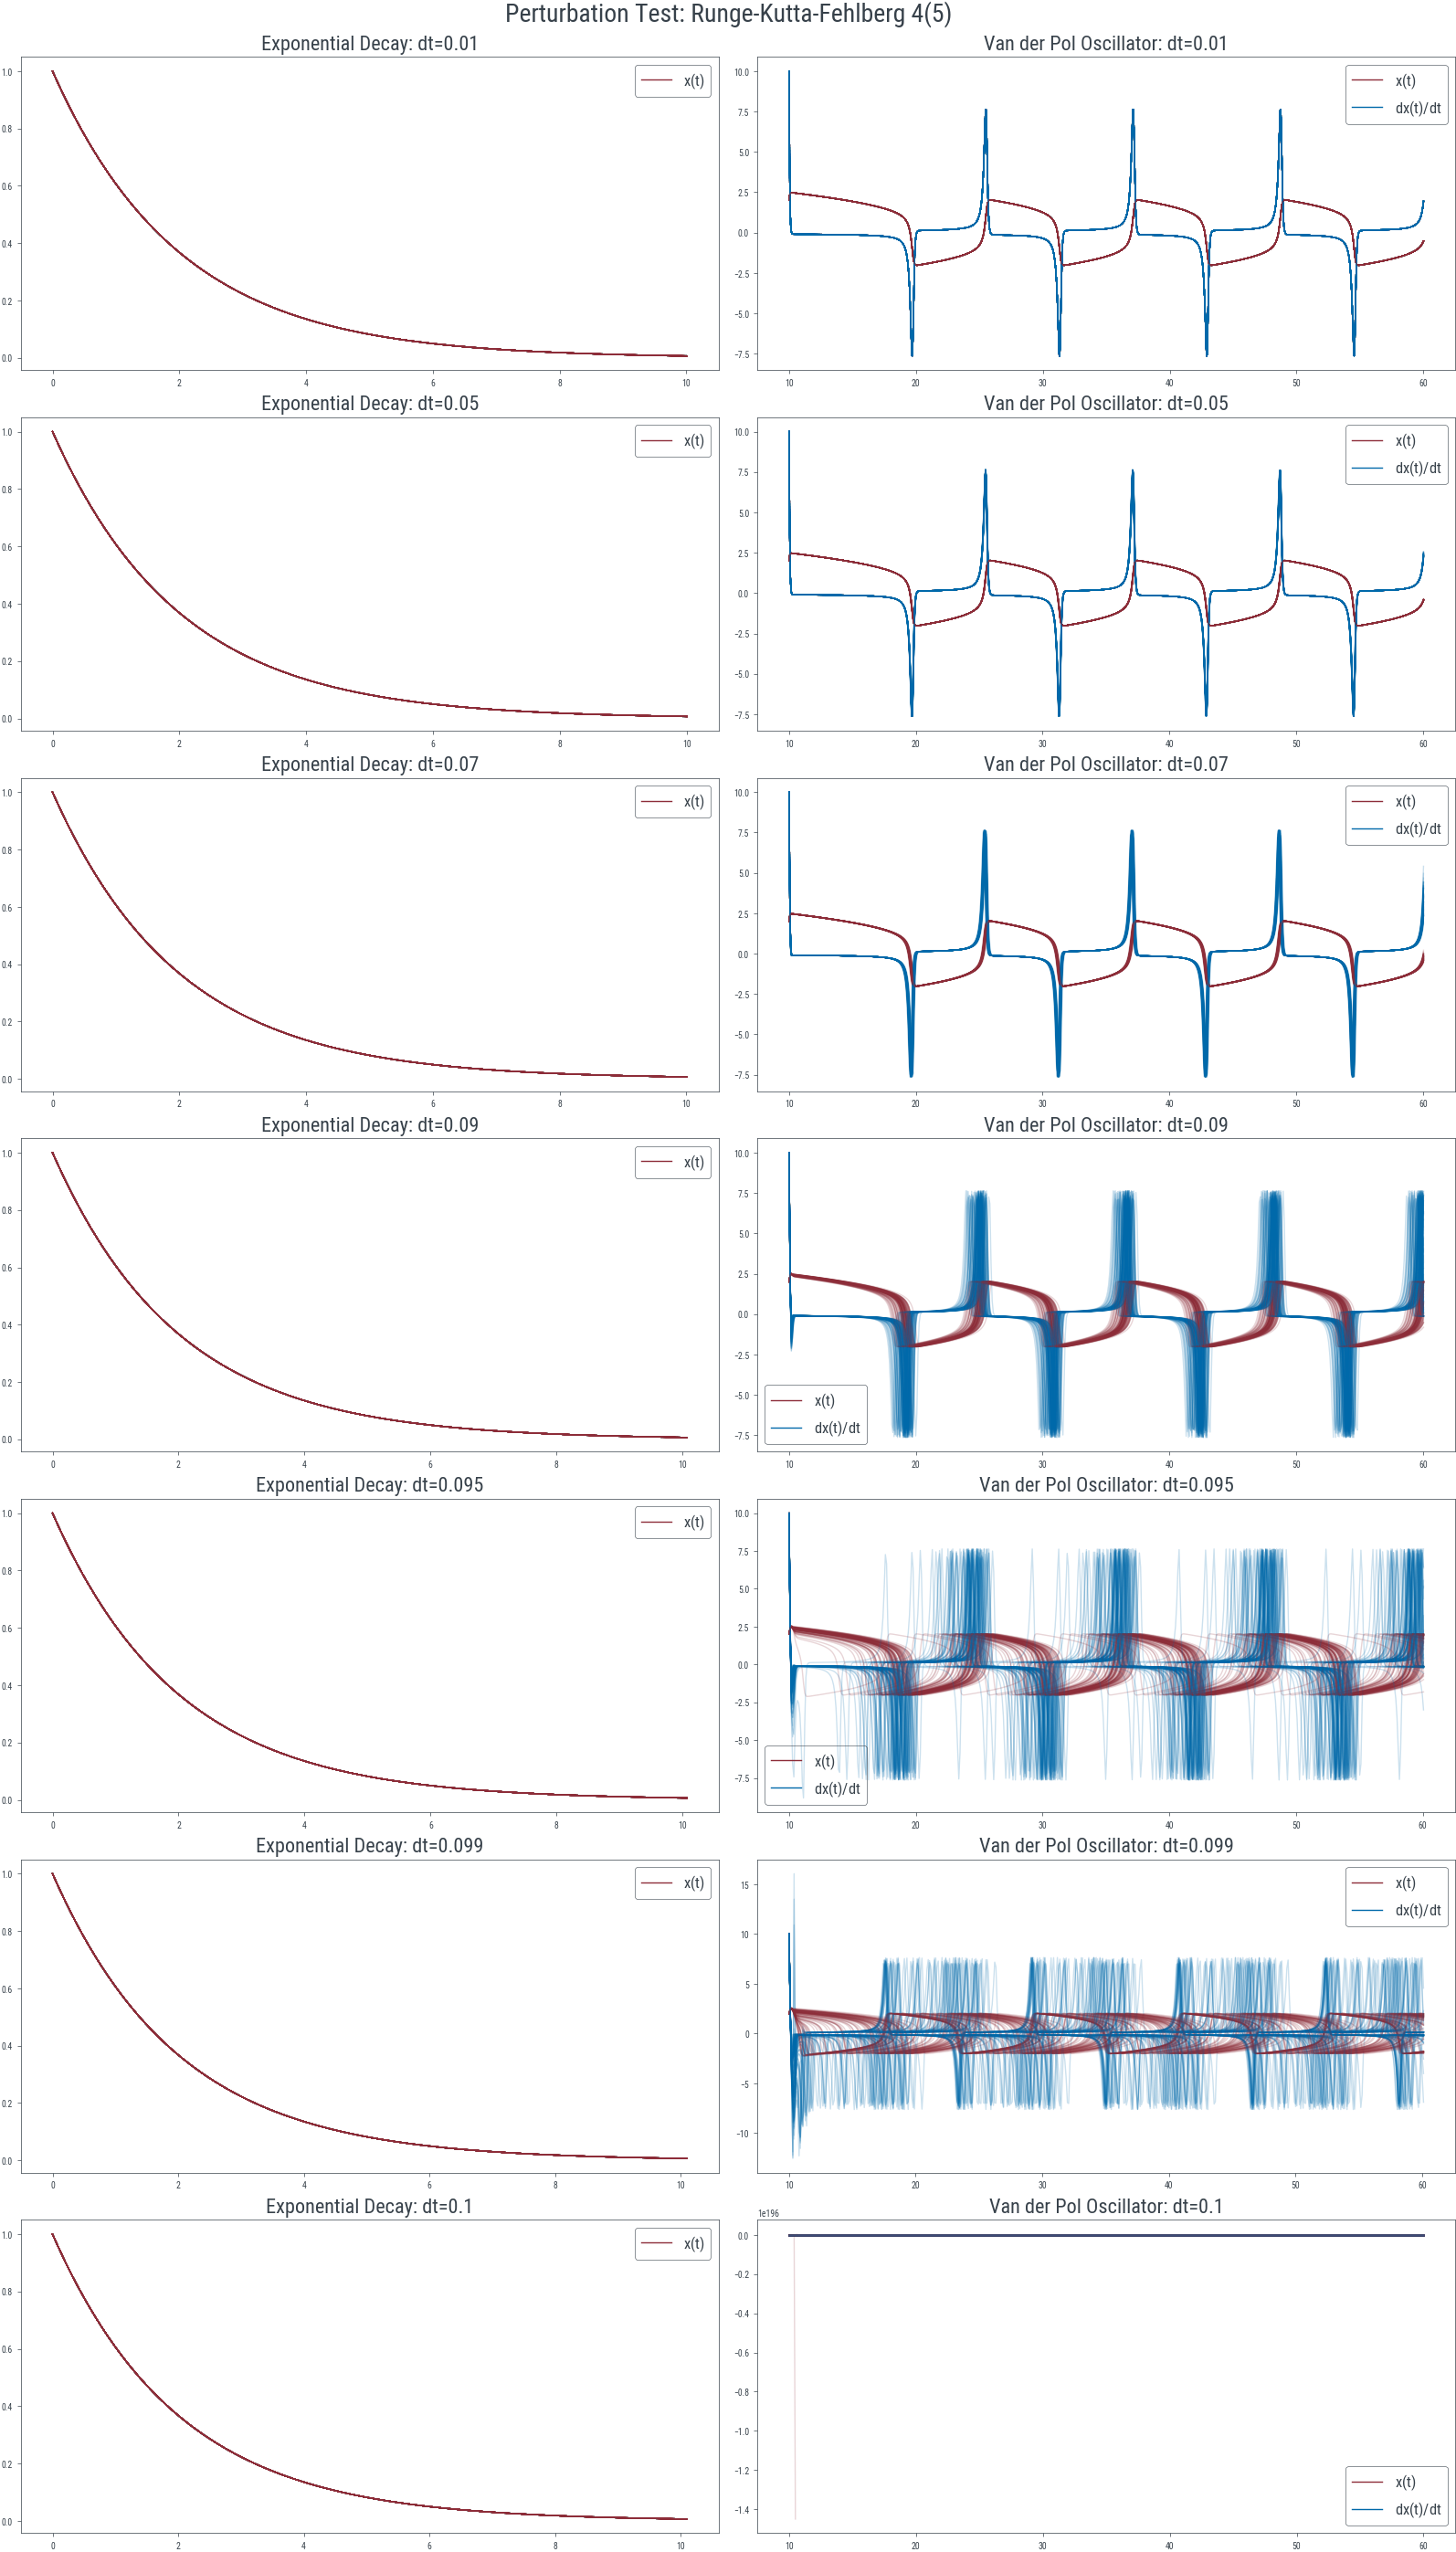

In [16]:
def fn_label(idx):
    if idx > 1:
        return f"$d^{idx+1}x(t)/dt^{idx+1}$"
    elif idx == 1:
        return f"$dx(t)/dt$"
    else:
        return f"$x(t)$"

for solver_name, v1 in results.items():
    fig, axs = plt.subplots(len(dts), len(odes), figsize=(len(odes)*8, len(dts)*4))
    for col, (ode_name, v2) in enumerate(v1.items()):
        for row, (dt, (ts, xss)) in enumerate(v2.items()):
            for xs in xss:
                for idx in range(xs.shape[1]):
                    axs[row, col].plot(ts, xs[:, idx, 0], color=colors[idx], alpha=0.2)
            handles = [Line2D([0], [0], label=fn_label(idx), color=colors[idx]) for idx in range(xss[0].shape[1])]
            axs[row, col].set_title(f"{ode_name}: dt={dt}", fontsize=16)
            axs[row, col].legend(handles=handles, fontsize=12)
    fig.suptitle(f"Perturbation Test: {solver_name}", fontsize=20)